# demo: TextGraphs + LLMs to construct a 'lemma graph'

_TextGraphs_ library is intended for iterating through a sequence of paragraphs.

## intro

In [1]:
import pathlib
from IPython.display import display, HTML, Image
display(HTML(pathlib.Path("docs/demo/blurb.1.html").read_text(encoding = "utf-8")))

## parse a document

In [2]:
from icecream import ic
from pyinstrument import Profiler
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
import spacy

import textgraphs

provide the source text

In [3]:
SRC_TEXT: str = """                                                                                                                      
Werner Herzog is a remarkable filmmaker and an intellectual originally from Germany, the son of Dietrich Herzog.
Although in fact Werner Herzog never really liked his father, as we all know.
After the war, Werner fled to America to become famous.
"""

set up the statistical stack profiling

In [4]:
profiler: Profiler = Profiler()
profiler.start()

set up the `TextGraphs` pipeline

In [5]:
tg: textgraphs.TextGraphs = textgraphs.TextGraphs(
    factory = textgraphs.PipelineFactory(
        spacy_model = textgraphs.SPACY_MODEL,
        ner_model = None,
        kg = textgraphs.WikiDatum(
            spotlight_api = textgraphs.DBPEDIA_SPOTLIGHT_API,
            dbpedia_search_api = textgraphs.DBPEDIA_SEARCH_API,
    		wikidata_api = textgraphs.WIKIDATA_API,
        ),
        infer_rels = [
    		textgraphs.InferRel_OpenNRE(
                model = textgraphs.OPENNRE_MODEL,
                max_skip = textgraphs.MAX_SKIP,
                min_prob = textgraphs.OPENNRE_MIN_PROB,
    		),
            textgraphs.InferRel_Rebel(
                lang = "en_XX",
                mrebel_model = textgraphs.MREBEL_MODEL,
            ),
        ],
    ),
)

pipe: textgraphs.Pipeline = tg.create_pipeline(
    SRC_TEXT.strip(),
)

## visualize the parse results

In [6]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "ent",
    jupyter = True,
)

In [7]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "dep",
    jupyter = True,
)

## collect graph elements from the parse

In [8]:
tg.collect_graph_elements(
    pipe,
    debug = False,
)

In [9]:
ic(len(tg.nodes.values()));
ic(len(tg.edges.values()));

ic| len(tg.nodes.values()): 50
ic| len(tg.edges.values()): 54


## perform entity linking

In [10]:
tg.perform_entity_linking(
    pipe,
	min_alias = textgraphs.DBPEDIA_MIN_ALIAS,
    min_similarity = textgraphs.DBPEDIA_MIN_SIM,
    debug = False,
)

## construct a lemma graph

In [11]:
tg.construct_lemma_graph(
    debug = False,
)

## infer relations

In [22]:
inferred_edges: list = await tg.infer_relations(
    pipe,
    debug = False,
)

inferred_edges

[Edge(src_node=0, dst_node=10, kind=<RelEnum.INF: 2>, rel='https://schema.org/nationality', prob=1.0, count=2),
 Edge(src_node=0, dst_node=10, kind=<RelEnum.INF: 2>, rel='https://schema.org/nationality', prob=1.0, count=2),
 Edge(src_node=15, dst_node=0, kind=<RelEnum.INF: 2>, rel='https://schema.org/children', prob=1.0, count=1),
 Edge(src_node=25, dst_node=0, kind=<RelEnum.INF: 2>, rel='https://schema.org/children', prob=1.0, count=1),
 Edge(src_node=40, dst_node=35, kind=<RelEnum.INF: 2>, rel='https://schema.org/event', prob=1.0, count=1)]

## extract ranked entities

In [13]:
tg.calc_phrase_ranks(
    pr_alpha = textgraphs.PAGERANK_ALPHA,
    debug = False,
)

show the resulting entities extracted from the document

In [14]:
df: pd.DataFrame = tg.get_phrases_as_df(pipe)
df

,node_id,text,pos,label,count,weight
0,0,Werner Herzog,PROPN,dbr:Werner_Herzog,2,0.067458
1,10,Germany,PROPN,dbr:Germany,1,0.066208
2,15,Dietrich Herzog,PROPN,dbo:Person,1,0.062909
3,20,fact,NOUN,None,1,0.062909
4,35,war,NOUN,None,1,0.062909
5,37,Werner,PROPN,dbo:Person,1,0.062909
6,40,America,PROPN,dbo:Country,1,0.062909
7,45,a remarkable filmmaker,noun_chunk,None,1,0.062909
8,4,filmmaker,NOUN,None,1,0.061828
9,46,an intellectual,noun_chunk,None,1,0.061654


## visualize the lemma graph

In [15]:
render: textgraphs.RenderPyVis = textgraphs.RenderPyVis(
    tg.nodes,
    tg.edges,
    tg.lemma_graph,
)

pv_graph: pyvis.network.Network = render.render_lemma_graph(
    pipe,
    debug = False,
)

initialize the layout parameters

In [16]:
pv_graph.force_atlas_2based(
    gravity = -38,
    central_gravity = 0.01,
    spring_length = 231,
    spring_strength = 0.7,
    damping = 0.8,
    overlap = 0,
)

pv_graph.show_buttons(filter_ = [ "physics" ])
pv_graph.toggle_physics(True)

In [17]:
pv_graph.prep_notebook()
pv_graph.show("vis.html")

vis.html


## generate a word cloud

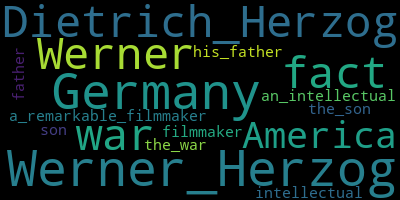

In [18]:
wordcloud = render.generate_wordcloud()
display(wordcloud.to_image())

## cluster communities in the lemma graph

In the tutorial
<a href="https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a" target="_blank">"How to Convert Any Text Into a Graph of Concepts"</a>, 
Rahul Nayak uses the
<a href="https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm"><em>girvan-newman</em></a>
algorithm to split the graph into communities, then clusters on those communities.
His approach works well for unsupervised clustering of key phrases which have been extracted from many documents.
In contrast, Nayak was working with entities extracted from "chunks" of text, not with a text graph.

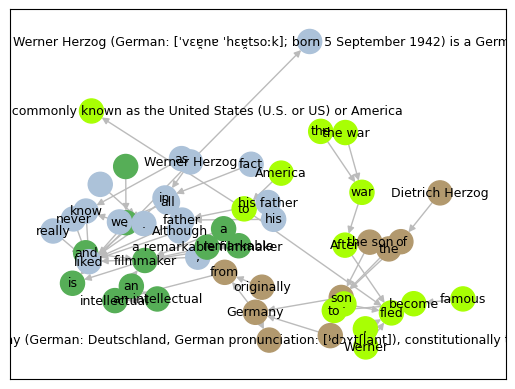

In [19]:
render.draw_communities();

## statistical stack profile instrumentation

In [20]:
profiler.stop()

In [21]:
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 18:46:35  Samples:  5821
 /_//_/// /_\ / //_// / //_'/ //     Duration: 39.570    CPU time: 21.575
/   _/                      v4.6.1

Program: /Users/paco/src/textgraphs/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /Users/paco/Library/Jupyter/runtime/kernel-b6d20dd1-912f-45cf-8dab-fb080c7db540.json

39.571 _UnixSelectorEventLoop._run_once  asyncio/base_events.py:1815
└─ 39.569 Handle._run  asyncio/events.py:78
      [35 frames hidden]  asyncio, ipykernel, IPython, matplotlib
         38.411 ZMQInteractiveShell.run_ast_nodes  IPython/core/interactiveshell.py:3391
         ├─ 19.272 <module>  ../ipykernel_58623/2495973708.py:1
         │  └─ 19.272 TextGraphs.perform_entity_linking  textgraphs/doc.py:523
         │     ├─ 10.744 Pipeline.link_dbpedia_search_entities  textgraphs/pipe.py:244
         │     │  └─ 10.737 WikiDatum.dbpedia_search_entity  textgraphs/kg.py:251
         │     │     └─ 10.662 get  requests/api.py:62
  

## outro

_\[ more parts are in progress, getting added to this demo \]_